In [17]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# User Inputs

In [18]:
#==========
# General Setting
#==========

# set core path
path = '/Users/Mark/Documents/Github/Fantasy_Football/'

db_name = 'Model_Inputs.sqlite3'

# set to position to analyze: 'RB', 'WR', 'QB', or 'TE'
set_pos = 'Rookie_WR'

# set the year
set_year = 2019


#==========
# Postgres Database
#==========

# postgres login information
pg_log = {
    'USER': 'postgres',
    'PASSWORD': 'Ctdim#1bf!!!!!',
    'HOST': 'localhost',
    'PORT': '5432', 
    'DATABASE_NAME': 'fantasyfootball'
}

# create engine for connecting to database
engine = create_engine('postgres+psycopg2://{}:{}@{}:{}/{}'.format(pg_log['USER'], pg_log['PASSWORD'], pg_log['HOST'],
                                                                   pg_log['PORT'], pg_log['DATABASE_NAME']))

# specify schema and table to write out intermediate results
table_info = {
    'engine': engine,
    'schema': 'websitedev',
}

#==========
# Fantasy Point Values
#==========

# define point values for all statistical categories
pass_yd_per_pt = 0.04 
pass_td_pt = 5
int_pts = -2
sacks = -1
rush_yd_per_pt = 0.1 
rec_yd_per_pt = 0.1
rush_rec_td = 7
ppr = 0.5
fumble = -2

# creating dictionary containing point values for each position
pts_dict = {}
pts_dict['QB'] = [pass_yd_per_pt, pass_td_pt, rush_yd_per_pt, rush_rec_td, int_pts, sacks, fumble]
pts_dict['RB'] = [rush_yd_per_pt, rec_yd_per_pt, ppr, rush_rec_td, fumble]
pts_dict['WR'] = [rec_yd_per_pt, ppr, rush_rec_td, fumble]
pts_dict['TE'] = [rec_yd_per_pt, ppr, rush_rec_td, fumble]


#==========
# Model Settings
#==========

# correlation with target for initial feature reduction
corr_cutoff = 0.15

# VIF threshold to include remaining features
vif_thresh = 10

# Load Packages

In [19]:
# core packages
import pandas as pd
import numpy as np
import os
import sqlite3

# jupyter specifications
pd.options.mode.chained_assignment = None
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# plotting functions
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# change directory temporarily to helper scripts
os.chdir(path + 'Scripts/Analysis/Helper_Scripts')

# load custom plot functions
from my_plot import PrettyPlot
PrettyPlot(plt)

# load custom helper functions and ensure lightgbm runs
from helper_functions import *
os.environ['KMP_DUPLICATE_LIB_OK']='True';

# Pull In Data

In [21]:
# connect to database and pull in positional data
conn = sqlite3.connect(path + 'Data/' + db_name)
df = pd.read_sql_query('SELECT * FROM ' + set_pos + '_' + str(set_year), con=conn)
bad_ap = df[(df.player == 'Adrian Peterson') & (df.avg_pick > 100)].index
df = df.drop(bad_ap, axis=0).reset_index(drop=True)

In [22]:
#=============
# Create parameter dictionaries for each algorithm
#=============

lgbm_params = {
    'n_estimators':[10, 20, 30, 40, 50, 60, 75],
    'max_depth':[2, 3, 4, 5, 6, 7],
    'feature_fraction':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'min_child_weight': [5, 10, 15, 20, 25, 30],
}

xgb_params = {
    'n_estimators': [20, 30, 40, 50, 60, 75], 
    'max_depth': [2, 3, 4, 5, 6, 7], 
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'min_child_weight': [10, 15, 20, 25, 30],
    'feature_fraction':[0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

rf_params = {
    'n_estimators': [30, 40, 50, 60, 75, 100, 125, 150], 
    'max_depth': [3, 4, 5, 6, 7], 
    'min_samples_leaf': [1, 2, 3, 5, 7, 10],
    'max_features':[0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

catboost_params = {
    'iterations': [10, 25, 50], 
    'depth': [1, 2, 3, 4, 5, 10]
}

ridge_params = {
    'alpha': [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 1000]
}

lasso_params = {
   # 'alpha': [0.5, 0.75, 0.8, .9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
    'alpha': [1, 5, 10, 25, 50, 100, 150, 200, 250]
}

lasso_pca_params = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 2]
}

In [23]:
def cv_estimate(est, X_train, y_train, n_folds=5):

    cv = KFold(n_folds, random_state=1234)
    val_scores = []
    out_of_sample_pred = []
    all_y = []
    for train, test in cv.split(X_train):
        est.fit(X_train.iloc[train, :], y_train[train])
        pred = est.predict(X_train.iloc[test, :])
        rmse = np.sqrt(mean_squared_error(pred, y_train[test]))
        val_scores.append(rmse)
        out_of_sample_pred.extend(pred)
        all_y.extend(y_train[test])

    result = np.mean(val_scores)
    print('Val Score:', round(np.mean(val_scores), 2))

    return out_of_sample_pred, all_y

In [28]:
if set_pos == 'Rookie_RB':
    metrics = ['rush_yd_per_game', 'rec_yd_per_game', 'rec_per_game', 'td_per_game']
elif set_pos == 'Rookie_WR':
    metrics = ['rec_yd_per_game', 'rec_per_game', 'td_per_game']

models = [LGBMRegressor(), XGBRegressor(), Lasso(), Ridge()]
model_label = ['LGBM', 'XGB', 'Lasso', 'Ridge']
params = [lgbm_params, xgb_params, lasso_params, ridge_params]

results = pd.DataFrame()
val_df = pd.DataFrame()
y_df = pd.DataFrame()
for y_label in metrics:
    
    predict = df[df.year==(set_year - 1)].reset_index(drop=True)
    train = df[df.year!=(set_year - 1)].reset_index(drop=True)
    to_drop = [m for m in metrics if m != y_label]
    to_drop.extend(['team'])
    train = train.rename(columns={y_label: 'y_act'}).drop(to_drop, axis=1)
    predict = predict.drop(to_drop, axis=1)

    # remove low correlation features
    train, predict = corr_removal(train, predict, corr_cutoff=corr_cutoff)

    # select only features with low vif for modeling
    transformer = ReduceVIF(thresh=vif_thresh, scale=True, print_progress=False)
    train_ = transformer.fit_transform(train.drop(['player'], axis=1), train.y_act)

    # extract best columns and filter down df_predict
    best_cols = list(train_.columns)
    best_cols.extend(['player', 'year', 'avg_pick'])
    best_cols = [c for c in best_cols if c != 'y_act']
    predict = predict[best_cols]
    predict = predict.loc[:,~predict.columns.duplicated()]

    # add target and filter down df_train
    best_cols = list(train_.columns)
    best_cols.extend(['y_act', 'year', 'avg_pick'])
    train = train[best_cols]
    train = train.loc[:,~train.columns.duplicated()]

    y = train.y_act
    X = train.drop('y_act', axis=1)
    
    val = []
    all_y = []
    for i, model in enumerate(models):

        grid = RandomizedSearchCV(model, params[i], cv=5, n_iter=20, random_state=1234,
                                  scoring='neg_mean_squared_error')
        
        if model_label == 'Ridge' or model_label == 'Lasso':
            X = StandardScaler().fit_transform(X)
        
        grid.fit(X, y)
        best_model = grid.best_estimator_
        p = best_model.predict(predict.drop('player', axis=1))
           
        results = pd.concat([results, pd.Series(p)], axis=1)
        
        test, ys = cv_estimate(best_model, X, y)        
        val.append(test)
        all_y.append(ys)
    
    lr_predict, lr_y  = cv_estimate(LinearRegression(), train[['avg_pick', 'year']], y)
    val.append(lr_predict)
    all_y.append(lr_y)
        
    val_df = pd.concat([val_df, pd.DataFrame(val).T.mean(axis=1)], axis=1)
    y_df = pd.concat([y_df, pd.DataFrame(all_y).T.mean(axis=1)], axis=1)

Corr removed  64 / 101  features
Running VIF Feature Reduction


/Users/Mark/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Dropped  17 / 36  columns
Val Score: 16.18
Val Score: 15.28
Val Score: 16.6
Val Score: 16.03
Val Score: 16.51
Corr removed  66 / 101  features
Running VIF Feature Reduction
Dropped  15 / 34  columns
Val Score: 1.25
Val Score: 1.21
Val Score: 1.32
Val Score: 1.21
Val Score: 1.24
Corr removed  83 / 101  features
Running VIF Feature Reduction
Dropped  4 / 17  columns
Val Score: 0.17
Val Score: 0.17
Val Score: 0.18
Val Score: 0.18
Val Score: 0.18


In [29]:
np.sqrt(np.mean((val_df - y_df)**2))

0    16.156177
0     1.247720
0     0.181647
dtype: float64

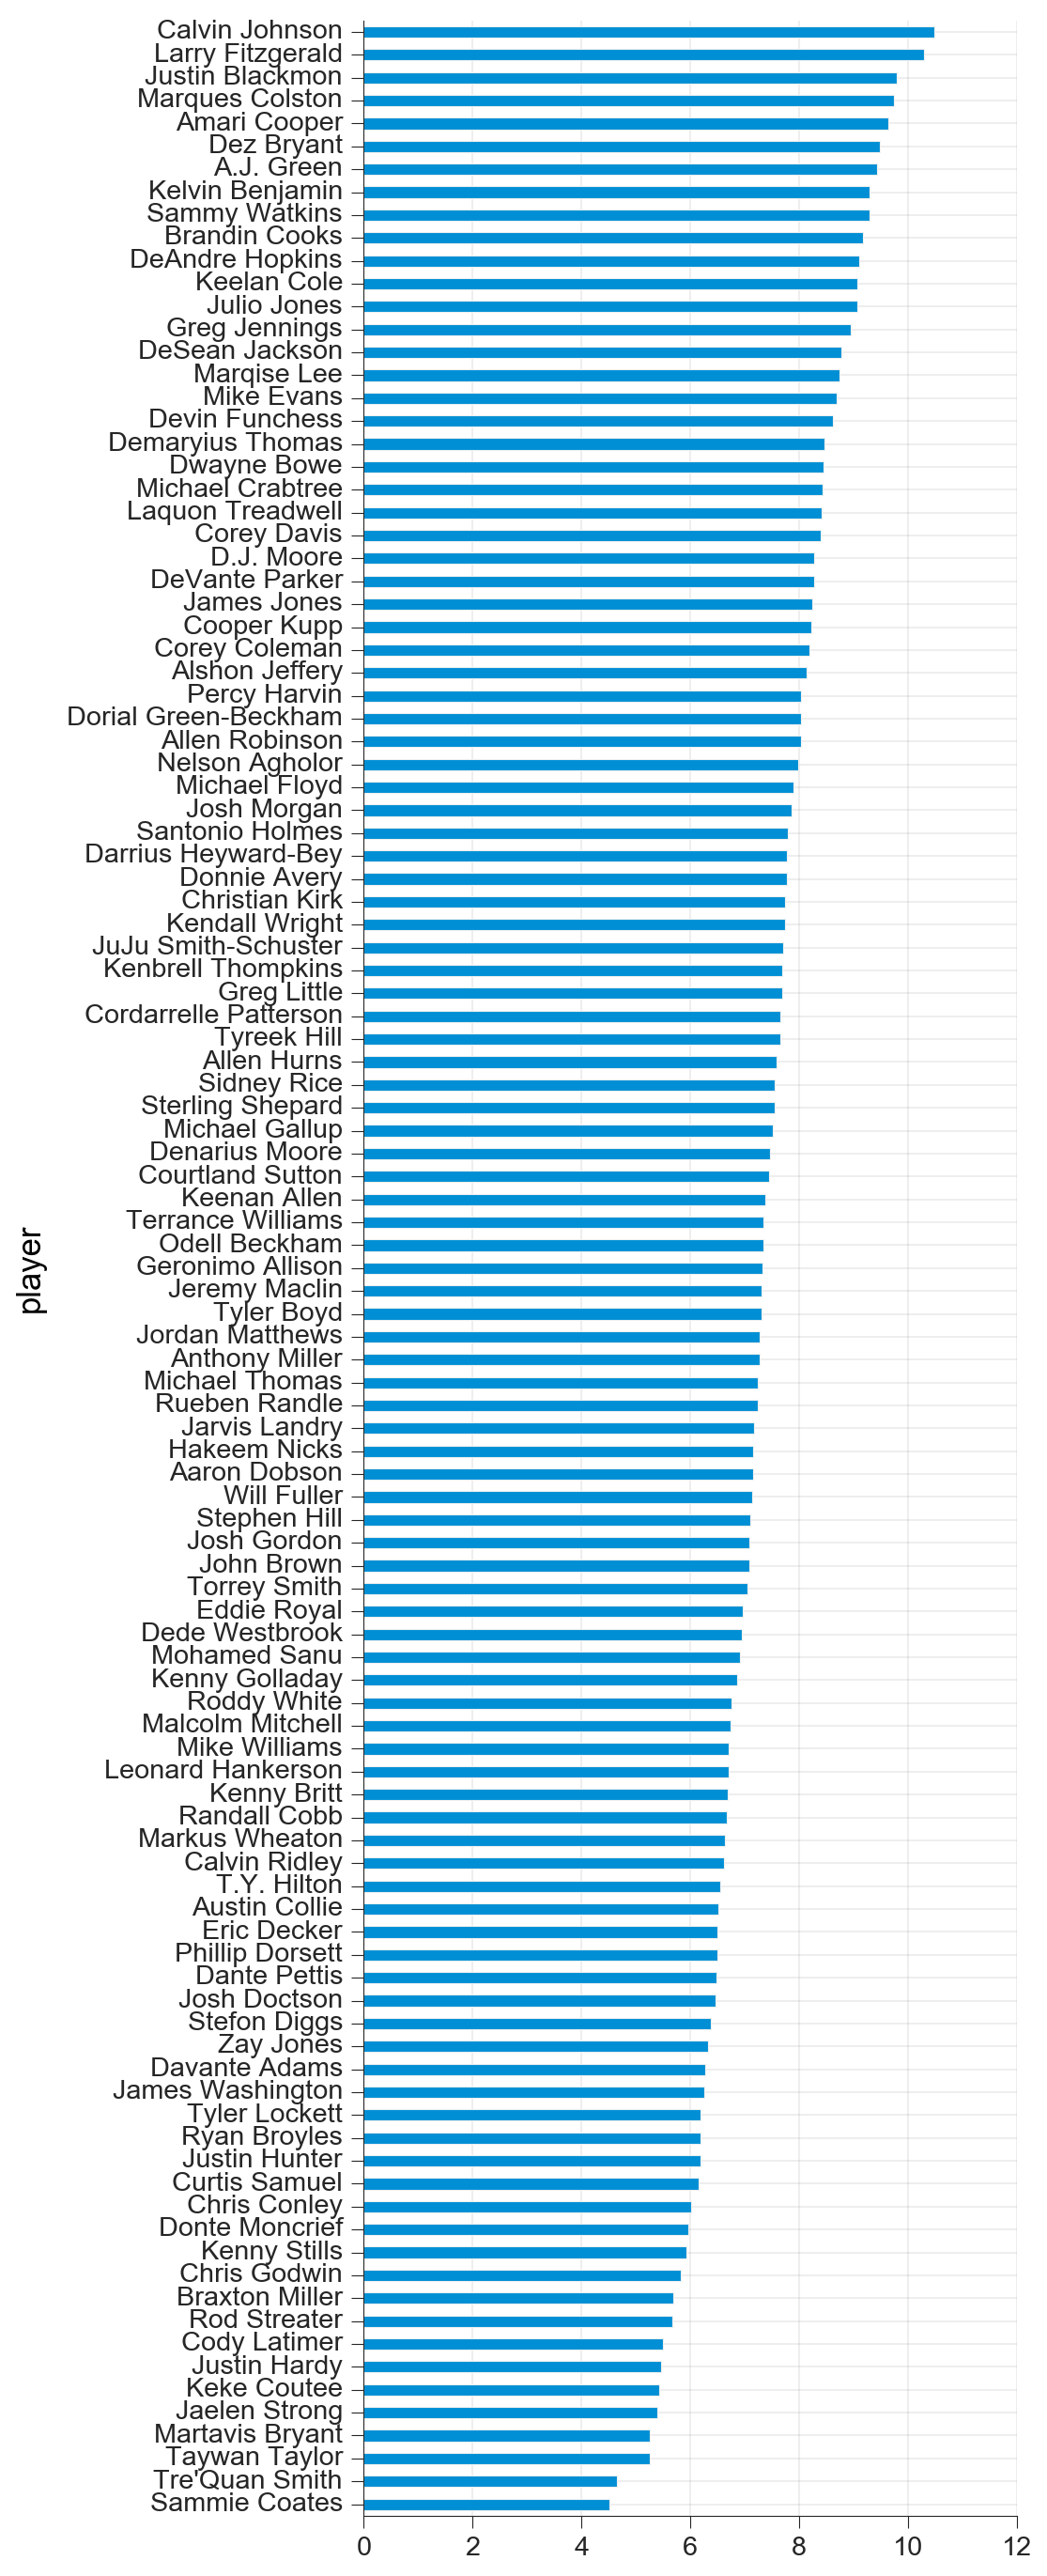

In [30]:
if set_pos == 'Rookie_RB':
    pts = [.1, .1, .5, 7]
elif set_pos == 'Rookie_WR':
    pts = [.1, .5, 7]

historical = pd.Series((val_df*pts).sum(axis=1).values, index=df[df.year!=2018].player)
historical.sort_values().plot.barh(figsize=(5,20))

In [35]:
df['year_exp'] = 0
train_out = pd.concat([df.loc[df.year!=2018, ['player', 'year']].reset_index(drop=True),
                       val_df,
                       df.loc[df.year!=2018, ['pp_age', 'year_exp', 'avg_pick']].reset_index(drop=True), 
                       (y_df*pts).sum(axis=1)], axis=1)
cols = ['player', 'year']
m = ['pred_' + m for m in metrics]
cols.extend(m)
cols.extend(['age', 'year_exp', 'avg_pick', 'y_act'])
train_out.columns = cols
train_out['avg_pick'] = np.log(train_out.avg_pick)
train_out['age'] = np.log(train_out.age)

In [37]:
sum_results = pd.DataFrame()
for i in range(0, results.shape[1], 4):
    sum_results = pd.concat([sum_results, results.iloc[:, i:(i+4)].mean(axis=1)], axis=1)
    
sum_results.columns = metrics
sum_results['fp_per_game'] = (sum_results*pts).sum(axis=1)

In [38]:
pd.concat([df.loc[df.year==2018, ['player']].reset_index(drop=True), sum_results], axis=1).sort_values(by='fp_per_game', ascending=False).reset_index(drop=True)

,player,rec_yd_per_game,rec_per_game,td_per_game,fp_per_game
0,KeeSean Johnson,48.577204,3.248358,0.226517,8.067521
1,Preston Williams,45.374386,3.144437,0.237046,7.768978
2,Andy Isabella,43.723270,3.252475,0.223148,7.560601
3,A.J. Brown,37.680420,2.876416,0.242692,6.905092
4,Deebo Samuel,33.330976,2.669220,0.277005,6.606741
5,N'Keal Harry,34.317963,2.577126,0.240832,6.406183
6,Hunter Renfrow,32.931424,2.554366,0.248119,6.307155
7,Jalen Hurd,29.594572,2.464988,0.270090,6.082580
8,Terry McLaurin,28.016280,2.327323,0.251766,5.727653
9,Mecole Hardman,25.713706,2.456511,0.216427,5.314615


In [ ]:
test_out = pd.concat([df.loc[df.year==2018, ['player']].reset_index(drop=True),
                      set_year-1,
                      sum_results,
                      df.loc[df.year==2018, ['pp_age', 'year_exp', 'avg_pick']].reset_index(drop=True)], axis=1)
cols = ['player']
cols.extend(m)
cols.extend(['age', 'year_exp', 'avg_pick'])
test_out.columns = cols
test_out['avg_pick'] = np.log(test_out['avg_pick'])

In [ ]:
train_out.to_sql(set_pos.replace('Rookie_', '') + '_Train_' + str(set_year), 
                 engine, schema='websitedev', index=False, if_exists='append')
test_out.to_sql(set_pos.replace('Rookie_', '') + '_Test_' + str(set_year), 
                engine, schema='websitedev', index=False, if_exists='append')